In [1]:
#pip install yfinance

In [2]:
#pip install pandas-datareader

In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
%matplotlib inline 

In [4]:
start = datetime(2018,1,1)
end = datetime(2023,1,1)

In [5]:
one_mon = data.DataReader('DGS1MO', 'fred',start, end)
one_day = np.log(1+one_mon)/365

[*********************100%***********************]  1 of 1 completed


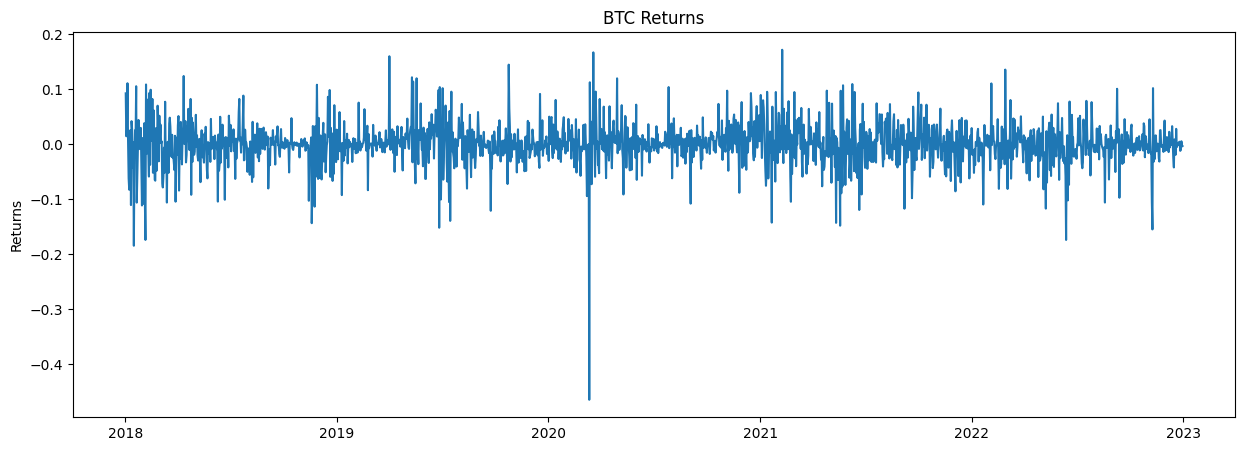

In [6]:
btc = yf.download('BTC-USD', start=start, end=end)
btc_returns = pd.DataFrame(np.diff(np.log(btc['Adj Close'].values)))
btc_returns.index = btc.index.values[1:btc.index.values.shape[0]]
btc_returns.columns = ['BTC Returns']

plt.figure(figsize=(15,5));
plt.plot(btc_returns);
plt.ylabel('Returns');
plt.title('BTC Returns');
plt.show();

In [7]:
btc_returns

,BTC Returns
2018-01-02,0.092589
2018-01-03,0.014505
2018-01-04,0.025858
2018-01-05,0.110945
2018-01-06,0.005578
...,...
2022-12-27,-0.012048
2022-12-28,-0.009895
2022-12-29,0.005409
2022-12-30,-0.002392


[*********************100%***********************]  1 of 1 completed


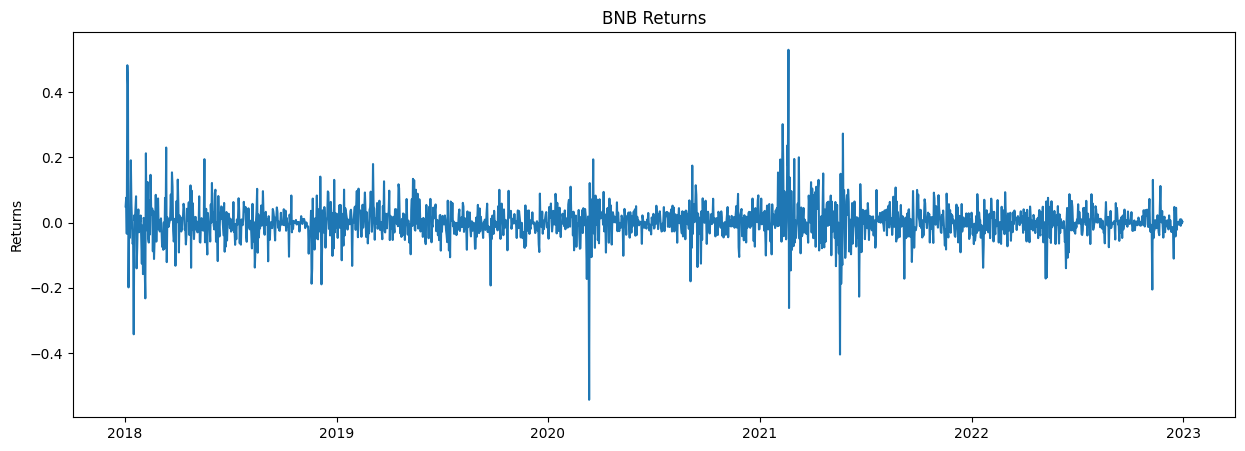

In [8]:
bnb = yf.download('BNB-USD', start=start, end=end)
bnb_returns = pd.DataFrame(np.diff(np.log(bnb['Adj Close'].values)))
bnb_returns.index = bnb.index.values[1:bnb.index.values.shape[0]]
bnb_returns.columns = ["BNB Returns"]

plt.figure(figsize=(15,5));
plt.plot(bnb_returns);
plt.ylabel('Returns');
plt.title("BNB Returns");
plt.show();

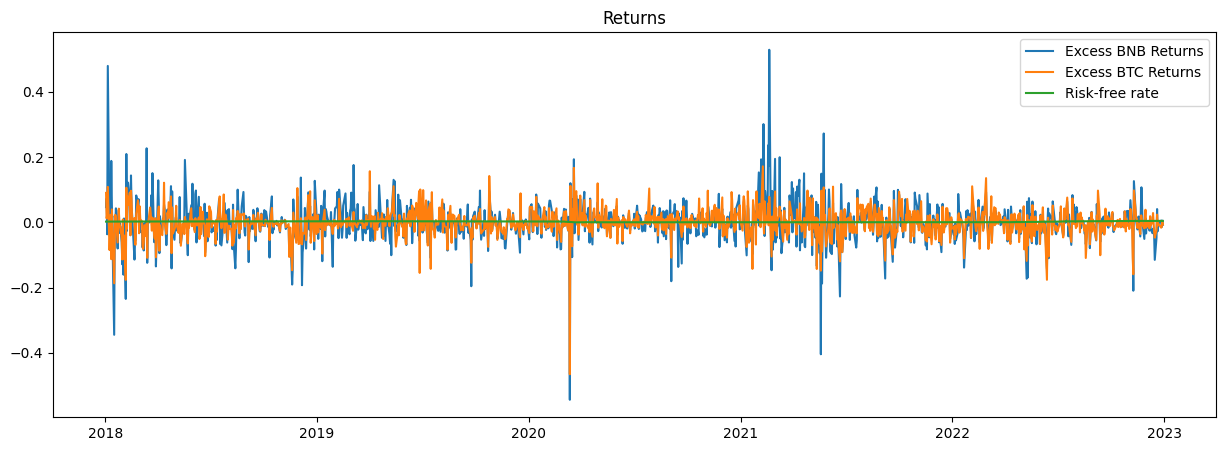

In [9]:
returns = pd.concat([one_day,bnb_returns,btc_returns],axis=1).dropna()
excess_bnb = returns["BNB Returns"].values - returns['DGS1MO'].values
excess_btc = returns["BTC Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_bnb,excess_btc, returns['DGS1MO'].values]))
final_returns.columns=["Excess BNB Returns","Excess BTC Returns","Risk-free rate"]
final_returns.index = returns.index

plt.figure(figsize=(15,5))
plt.title("Returns")
x = plt.plot(final_returns);
plt.legend(iter(x), final_returns.columns);

In [10]:
import statsmodels.api as sm

exog = excess_btc
exog = sm.add_constant(exog, prepend=True)
mod = sm.OLS(excess_bnb, exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     1219.
Date:                Wed, 08 Mar 2023   Prob (F-statistic):          6.16e-187
Time:                        10:11:07   Log-Likelihood:                 2128.0
No. Observations:                1250   AIC:                            -4252.
Df Residuals:                    1248   BIC:                            -4242.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.812      0.0

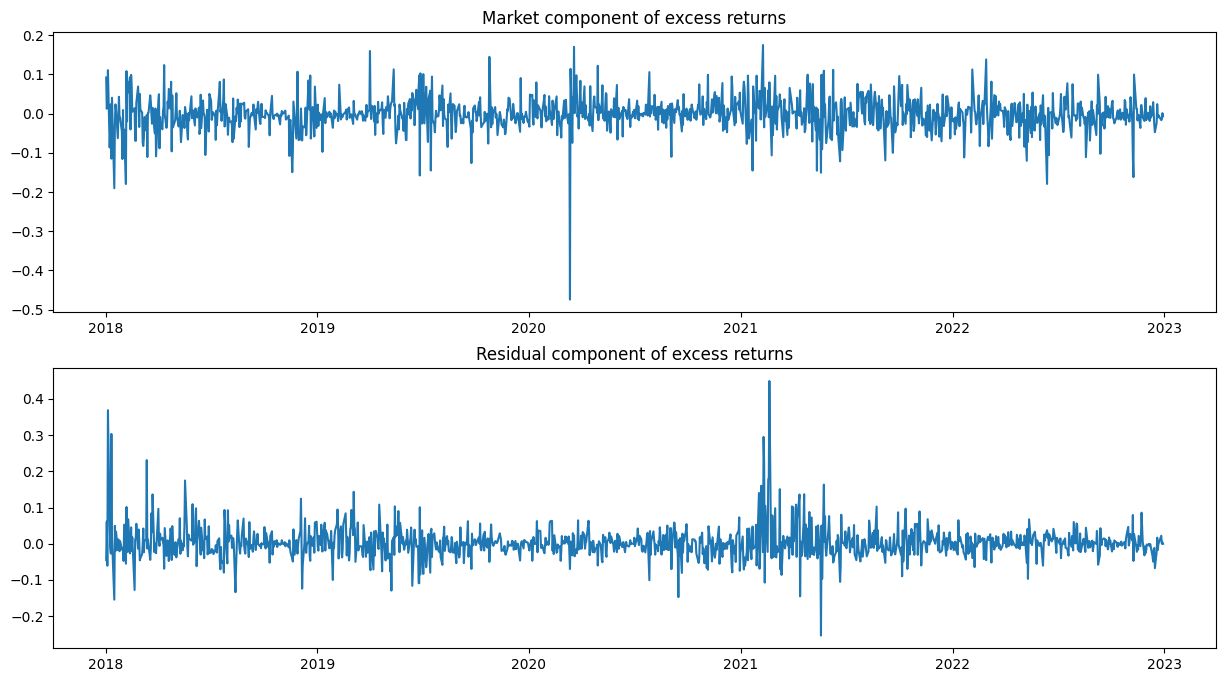

In [11]:
market_c = excess_btc*1.0183
residual_c = excess_bnb - market_c

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title("Market component of excess returns");
plt.plot(final_returns.index,market_c);
plt.subplot(212)
plt.title("Residual component of excess returns");
plt.plot(final_returns.index,residual_c);

In [12]:
eth = yf.download('ETH-USD', start=start, end=end)
eth_returns = pd.DataFrame(np.diff(np.log(eth['Adj Close'].values)))
eth_returns.index = eth.index.values[1:eth.index.values.shape[0]]
eth_returns.columns = ["ETH Returns"]

tet = yf.download('USDT-USD', start=start, end=end)
tet_returns = pd.DataFrame(np.diff(np.log(tet['Adj Close'].values)))
tet_returns.index = tet.index.values[1:tet.index.values.shape[0]]
tet_returns.columns = ["TET Returns"]

returns = pd.concat([one_day,eth_returns,tet_returns],axis=1).dropna()
excess_eth = returns["ETH Returns"].values - returns['DGS1MO'].values
excess_tet = returns["TET Returns"].values - returns['DGS1MO'].values

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
mod = sm.OLS(excess_eth, exog)
res = mod.fit()
print(res.summary())

mod = sm.OLS(excess_tet, exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     3352.
Date:                Wed, 08 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:11:09   Log-Likelihood:                 2673.5
No. Observations:                1250   AIC:                            -5343.
Df Residuals:                    1248   BIC:                            -5333.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.877      0.3

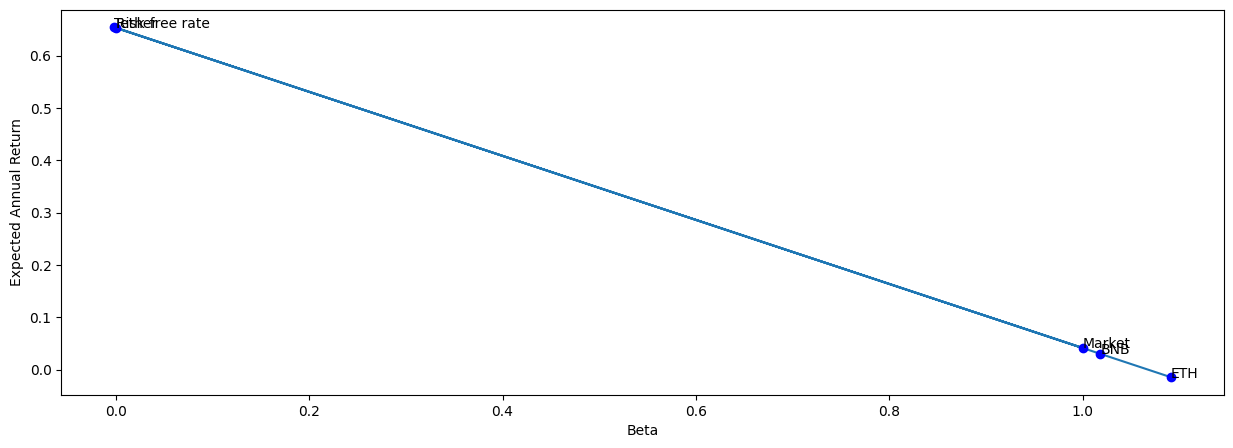

In [14]:
expected_btc = np.log(1+np.mean(excess_btc))*365
betas = np.array([0,1,-0.0017,1.0183,1.0912])
expected_rf = np.log(1+np.mean(returns['DGS1MO'].values))*365
expected_returns = betas*expected_btc + expected_rf
data_names = ['Risk-free rate', 'Market','Tether','BNB','ETH']

plt.figure(figsize=(15,5))
plt.plot(betas,expected_returns);
plt.plot(betas,expected_returns,'bo')

for i, txt in enumerate(expected_returns):
    plt.annotate(data_names[i], (betas[i],expected_returns[i]))

plt.xlabel("Beta");
plt.ylabel("Expected Annual Return");
plt.show()